## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [138]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

img = cv2.imread(images[0])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#print(len(images))

#Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Writing the output images to the output_images folder
        #cv2.imwrite("output_images/"+fname+"_CCoutput"+".jpg",img)

## Calibrate the camera and get the Camera Matrix and Distortion co-efficient

In [139]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [140]:
def cal_undistort(img, mtx, dist):    
    # Use cv2.undistort()    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

## Checking distortion correction on test_images

In [141]:
images = glob.glob('test_images/test*.jpg')
for each in images:
    #print(each[12:17])
    img = cv2.imread(each)
    dst = cal_undistort(img,mtx,dist)
    # Saving the undistorted images to the output dir
    cv2.imwrite("output_images/undistorted_images/"+each[12:17]+".jpg",dst)
images = glob.glob('test_images/straight_lines*.jpg')
for each in images:
    #print(each[12:27])
    img = cv2.imread(each)
    dst = cal_undistort(img,mtx,dist)
    #Saving the undistorted images to the output dir
    cv2.imwrite("output_images/undistorted_images/"+each[12:27]+".jpg",dst)    


## Selecting Source and Destination points for Perspective Transform 

In [160]:
img = mpimg.imread('output_images/undistorted_images/straight_lines1.jpg')
#plt.imshow(img)

img_size = (img.shape[1], img.shape[0])
src = np.float32([[595,449],[681,449] ,[200,720],[1120,720]])
dst = np.float32([[360,0],[1050,0] ,[360,720],[1050,720]])

def do_perspective_transform(img):
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()
#     ax1.imshow(img)
#     x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
#     y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
#     ax1.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
#     ax1.set_title('Original Undistorted Image', fontsize=30)
#     ax2.imshow(warped)
#     x = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
#     y = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
#     ax2.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
#     ax2.set_title('Perspective transformed Image', fontsize=30)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped
#do_perspective_transform(img)

## Carrying out Perspective Transform on all Undistorted test images

In [215]:
images = glob.glob('output_images/undistorted_images/test*.jpg')
for each in images:
    #print(each[33:38])
    img = mpimg.imread(each)
    warped=do_perspective_transform(img)
    # Save all perspective transformed images in output_images folder
    cv2.imwrite("output_images/perspective_transformed_images/"+each[33:38]+".jpg",warped)
images = glob.glob('output_images/undistorted_images/straight_lines*.jpg')
for each in images:
    #print(each[33:48])
    img = mpimg.imread(each)
    warped=do_perspective_transform(img)
    #Save all perspective transformed images in output_images folder
    cv2.imwrite("output_images/perspective_transformed_images/"+each[33:48]+".jpg",warped)    


## Function to calculate the gradient along a given direction

In [156]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient=='x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask = (scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[mask]=1
    # 6) Return this mask as your binary_output image
    
    return sxbinary

## Function to calculate the magnitude of the gradient

In [157]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.power(sobel_x,2)+np.power(sobel_y,2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    mask = (scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[mask]=1
    # 6) Return this mask as your binary_output image
    
    return sxbinary

## Function to calculate the direction of the gradient

In [158]:
def dir_threshold(img, sobel_kernel, thresh):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dirn_gradient = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    mask = (dirn_gradient >= thresh_min) & (dirn_gradient <= thresh_max)
    # 6) Return this mask as your binary_output image
    sxbinary = np.zeros_like(dirn_gradient)
    sxbinary[mask]=1
    return sxbinary

## Visualizing Sobel thresholds.
[Interactivity in Jupyter Notebooks](https://towardsdatascience.com/a-very-simple-demo-of-interactive-controls-on-jupyter-notebook-4429cf46aabd)

##  Absolute sobel threshold

## Function to visualize images

In [309]:
def visualize_Image(input,output,input_title,output_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(input);
    ax1.set_title(input_title, fontsize=30)
    ax2.imshow(output, cmap='gray');
    ax2.set_title(output_title, fontsize=30)

In [316]:
from ipywidgets import interact, interactive, fixed
def abs_sobel_update(thresh_min=21, thresh_max=201):
    test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
    output_img = abs_sobel_thresh(test_image, 'x', thresh_min, thresh_max)
    # Visualize sobel absolute threshold
    #visualize_Image(test_image,output_img,'Unwarped Image','Sobel Absolute')
    return output_img
interact(abs_sobel_update, 
         thresh_min=(0,255), 
         thresh_max=(0,255));

interactive(children=(IntSlider(value=21, description='thresh_min', max=255), IntSlider(value=201, description…

##  Sobel Magnitude threshold

In [317]:
from ipywidgets import interact, interactive, fixed
def mag_sobel_update(kernel_size=13, min_thresh=25, max_thresh=150):
    test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
    output_img = mag_thresh(test_image, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel magnitude threshold
    #visualize_Image(test_image,output_img,'Unwarped Image','Sobel Magnitude')
    return output_img
interact(mag_sobel_update, kernel_size=(3,31,2), 
                 min_thresh=(0,255), 
                 max_thresh=(0,255));

interactive(children=(IntSlider(value=13, description='kernel_size', max=31, min=3, step=2), IntSlider(value=2…

##  Sobel Direction threshold

In [318]:
def dir_sobel_update(kernel_size=7, min_thresh=0.2, max_thresh=0.9):
    test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
    output_img = dir_threshold(test_image, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel direction threshold
    #visualize_Image(test_image,output_img,'Unwarped Image','Sobel Direction')
    return output_img
interact(dir_sobel_update, kernel_size=(3,31,2), 
                 min_thresh=(0,np.pi/2,0.01), 
                 max_thresh=(0,np.pi/2,0.01));

interactive(children=(IntSlider(value=7, description='kernel_size', max=31, min=3, step=2), FloatSlider(value=…

### Sobel Magnitude and Sobel Absolute Threshold

In [320]:
test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
def dir_mag_sobel_update(mag_kernel_size=13, mag_min_thresh=25, mag_max_thresh=150, abs_min_thresh=21, abs_max_thresh=201):
    output_img_mag = mag_sobel_update(mag_kernel_size, mag_min_thresh, mag_max_thresh)
    output_img_abs = abs_sobel_update(abs_min_thresh, abs_max_thresh)
    combined = np.zeros_like(output_img_mag)
    combined[((output_img_mag == 1) | (output_img_abs == 1))] = 1
    # Visualize sobel magnitude and sobel direction threshold
    #visualize_Image(test_image,combined,'Unwarped Image','Sobel Magnitude and Absolute')

interact(dir_mag_sobel_update, mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255), 
                 abs_min_thresh=(0,255), 
                 abs_max_thresh=(0,255));


interactive(children=(IntSlider(value=13, description='mag_kernel_size', max=31, min=1, step=2), IntSlider(val…

## Visualize multiple color space channels

Text(0.5, 1.0, 'LAB B-Channel')

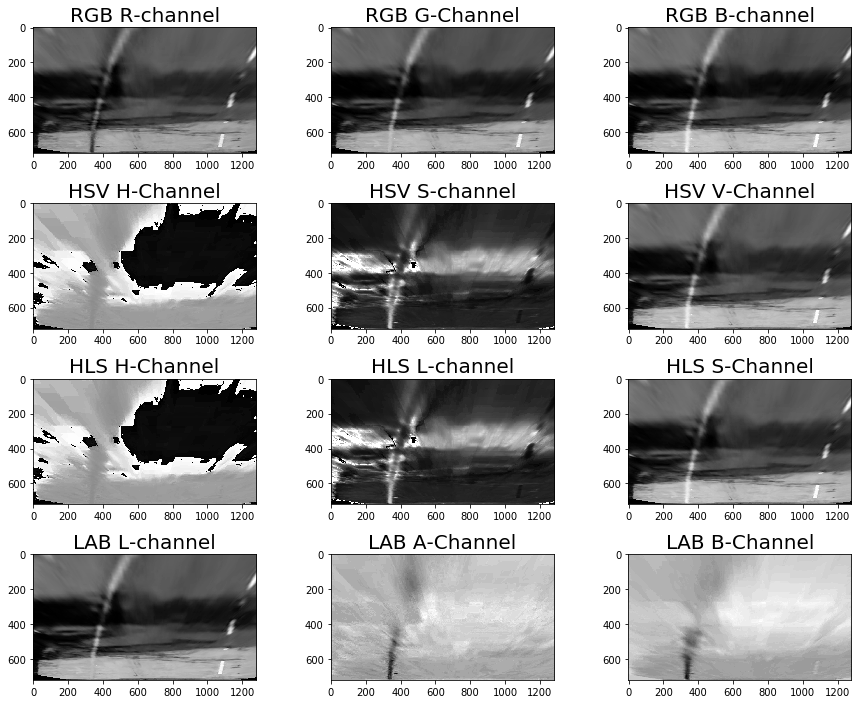

In [205]:
test_image = cv2.imread("output_images/perspective_transformed_images/test5.jpg")
test_image_R = test_image[:,:,0]
test_image_G = test_image[:,:,1]
test_image_B = test_image[:,:,2]
test_image_HSV = cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV)
test_image_H = test_image_HSV[:,:,0]
test_image_S = test_image_HSV[:,:,1]
test_image_V = test_image_HSV[:,:,2]
test_image_HLS = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)
test_image_HH = test_image_HSV[:,:,0]
test_image_LL = test_image_HSV[:,:,1]
test_image_SS = test_image_HSV[:,:,2]
test_image_LAB = cv2.cvtColor(test_image, cv2.COLOR_RGB2Lab)
test_image_L = test_image_LAB[:,:,0]
test_image_A = test_image_LAB[:,:,1]
test_image_LAB_B = test_image_LAB[:,:,2]
fig, axs = plt.subplots(4,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .4, wspace=.001)
axs = axs.ravel()
axs[0].imshow(test_image_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=20)
axs[1].imshow(test_image_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=20)
axs[2].imshow(test_image_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=20)
axs[3].imshow(test_image_H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=20)
axs[4].imshow(test_image_S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=20)
axs[5].imshow(test_image_V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=20)
axs[6].imshow(test_image_HH, cmap='gray')
axs[6].set_title('HLS H-Channel', fontsize=20)
axs[7].imshow(test_image_LL, cmap='gray')
axs[7].set_title('HLS L-channel', fontsize=20)
axs[8].imshow(test_image_SS, cmap='gray')
axs[8].set_title('HLS S-Channel', fontsize=20)
axs[9].imshow(test_image_L, cmap='gray')
axs[9].set_title('LAB L-channel', fontsize=20)
axs[10].imshow(test_image_A, cmap='gray')
axs[10].set_title('LAB A-Channel', fontsize=20)
axs[11].imshow(test_image_LAB_B, cmap='gray')
axs[11].set_title('LAB B-Channel', fontsize=20)

## Visualizing Colorspaces thresholding
[Colorspaces for lane detection](https://towardsdatascience.com/teaching-cars-to-see-advanced-lane-detection-using-computer-vision-87a01de0424f)
***
**Using the output of the above cell and the information in the above link we shall attempt only the following thresholds**.
**We shall first run the thresholds on one test_image and when we fine tune the thresholds**
**we shall then check the thresholds on all test images**

## RGB R channel Thresholding

In [212]:
def R_threshold(image,thresh=(0, 255)):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

## HLS S-channel Thresholding

In [182]:
def S_threshold(image,thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

## HLS L-channel Thresholding

In [376]:
def L_threshold(image,thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    L = L*(255/np.max(L))
    binary = np.zeros_like(L)
    binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary

## HSV V-channel Thresholding

In [184]:
def V_threshold(image,thresh=(0, 255)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    binary = np.zeros_like(V)
    binary[(V > thresh[0]) & (V <= thresh[1])] = 1
    return binary

## LAB L-channel Thresholding

In [185]:
def Lab_L_threshold(image,thresh=(0, 255)):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    L = lab[:,:,0]
    A = lab[:,:,1]
    B = lab[:,:,2]
    binary = np.zeros_like(L)
    binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary

## LAB B-channel Thresholding

In [372]:
def Lab_B_threshold(image,thresh=(0, 255)):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    L = lab[:,:,0]
    A = lab[:,:,1]
    B = lab[:,:,2]
    binary = np.zeros_like(B)
    if np.max(B) > 175:
        B= B*(255/np.max(B))
    binary[(B > thresh[0]) & (B <= thresh[1])] = 1
    return binary

In [366]:
test_image = cv2.imread("output_images/perspective_transformed_images/test6.jpg")#150,221
def R_color_update(min_thresh=224, max_thresh=255):
    output_img_R = R_threshold(test_image,(min_thresh, max_thresh)) 
    # Visualize R-channel threshold
    visualize_Image(test_image,output_img_R,'Undistorted Image','RGB R-Channel')
    
interact(R_color_update,
         min_thresh=(0,255), 
         max_thresh=(0,255));



interactive(children=(IntSlider(value=224, description='min_thresh', max=255), IntSlider(value=255, descriptio…

In [324]:
test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
def S_color_update(min_thresh=90, max_thresh=255):
    output_img_S = S_threshold(test_image,(min_thresh, max_thresh)) 
    
    # Visualize HLS S-channel threshold
    visualize_Image(test_image,output_img_S,'Undistorted Image','HLS S-Channel')
    
interact(S_color_update,
         min_thresh=(0,255), 
         max_thresh=(0,255));


interactive(children=(IntSlider(value=90, description='min_thresh', max=255), IntSlider(value=255, description…

In [381]:
test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
def L_color_update(min_thresh=220, max_thresh=255):
    output_img_L = L_threshold(test_image,(min_thresh, max_thresh)) 
    
    # Visualize HLS L-channel threshold
    visualize_Image(test_image,output_img_L,'Undistorted Image','HLS L-Channel')
    
interact(L_color_update,
         min_thresh=(0,255), 
         max_thresh=(0,255));

interactive(children=(IntSlider(value=220, description='min_thresh', max=255), IntSlider(value=255, descriptio…

In [382]:
test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
def V_color_update(min_thresh=120, max_thresh=255):
    output_img_V = V_threshold(test_image,(min_thresh, max_thresh)) 
    # Visualize HSV V-channel threshold
    visualize_Image(test_image,output_img_V,'Undistorted Image','HSV V-Channel')
interact(V_color_update,
         min_thresh=(0,255), 
         max_thresh=(0,255));

interactive(children=(IntSlider(value=120, description='min_thresh', max=255), IntSlider(value=255, descriptio…

In [327]:
test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
def L_color_update(min_thresh=125, max_thresh=250):
    output_img_L = L_threshold(test_image,(min_thresh, max_thresh))
    # Visualize LAB L-channel threshold
    visualize_Image(test_image,output_img_L,'Undistorted Image','LAB L-Channel')
interact(L_color_update,
         min_thresh=(0,255), 
         max_thresh=(0,255));

interactive(children=(IntSlider(value=125, description='min_thresh', max=255), IntSlider(value=250, descriptio…

In [375]:
test_image = cv2.imread("output_images/perspective_transformed_images/straight_lines1.jpg")
def Lab_B_color_update(min_thresh=190, max_thresh=255):
    output_img_B = Lab_B_threshold(test_image,(min_thresh, max_thresh))
    # Visualize LAB B-channel threshold
    visualize_Image(test_image,output_img_B,'Undistorted Image','LAB B-Channel')
interact(Lab_B_color_update,
         min_thresh=(0,255), 
         max_thresh=(0,255));

interactive(children=(IntSlider(value=190, description='min_thresh', max=255), IntSlider(value=255, descriptio…

## Pipeline for  image processing
### Takes an image and returns the lanes found 

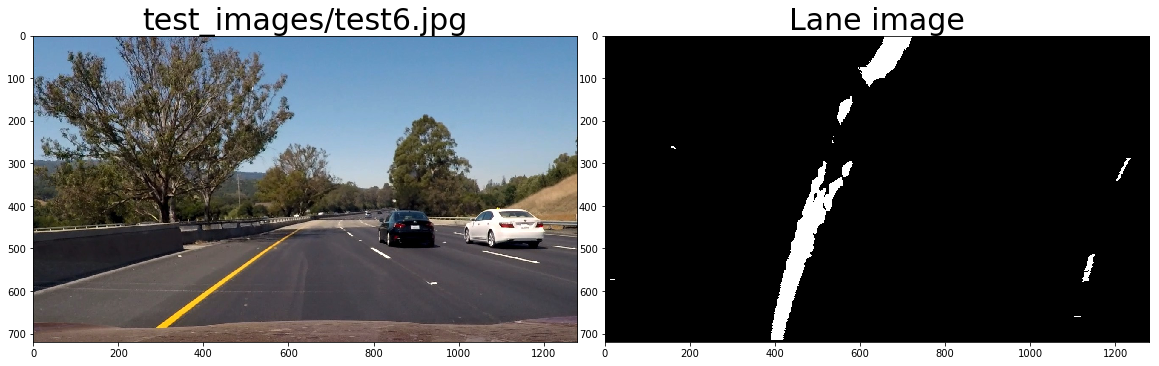

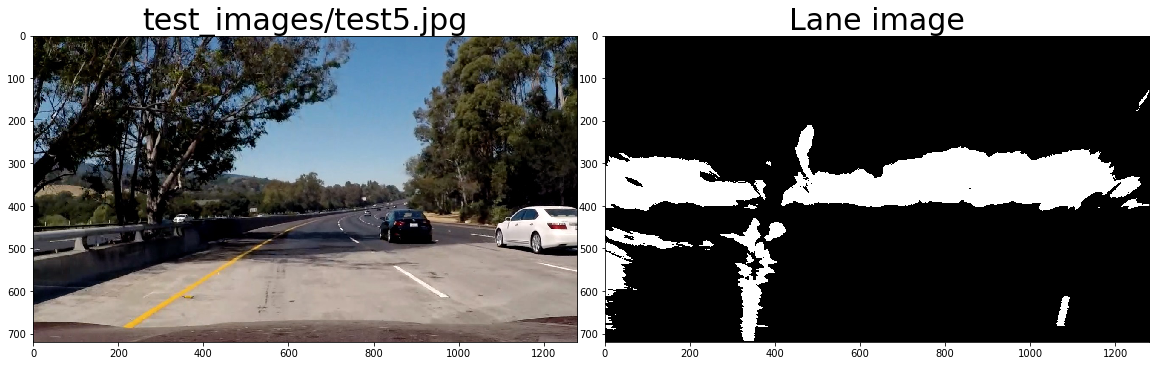

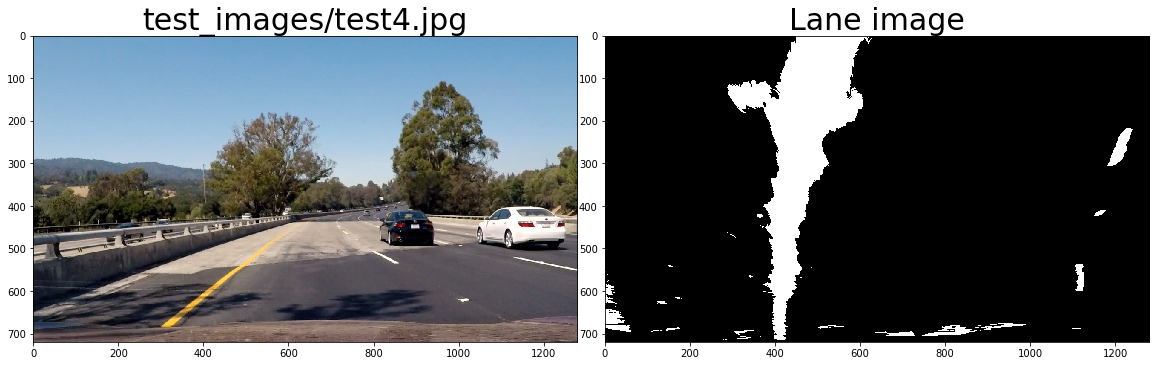

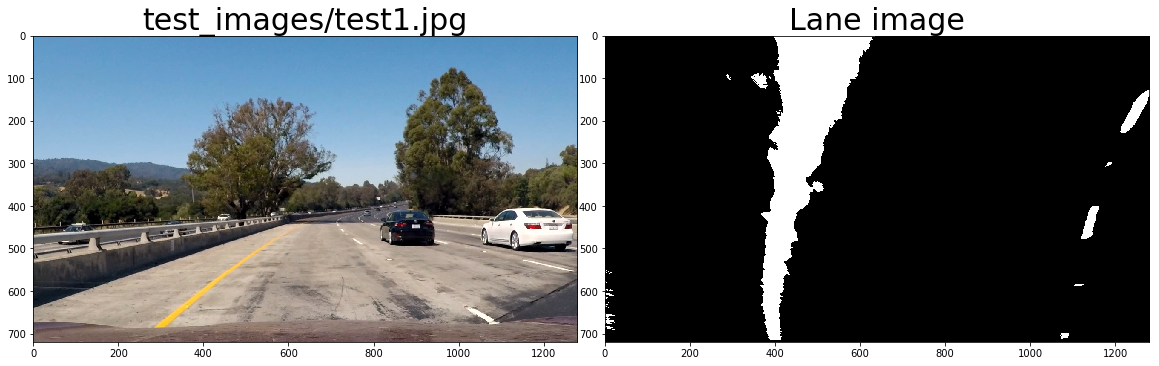

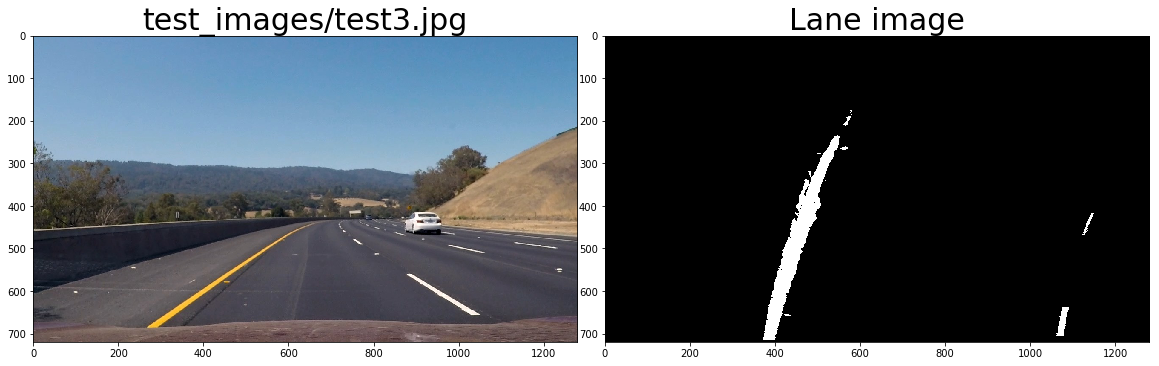

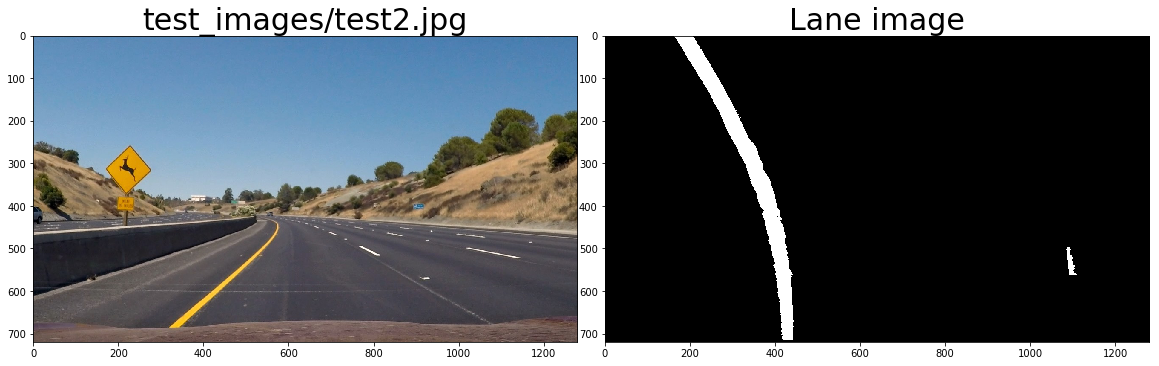

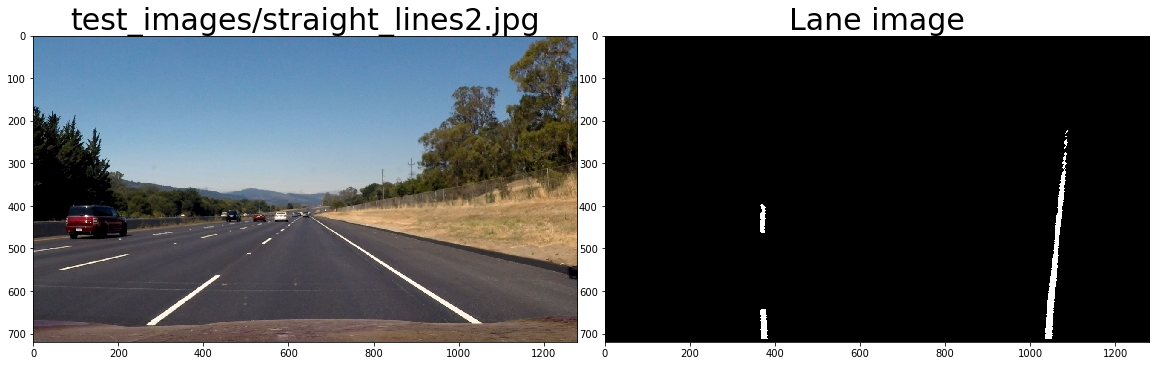

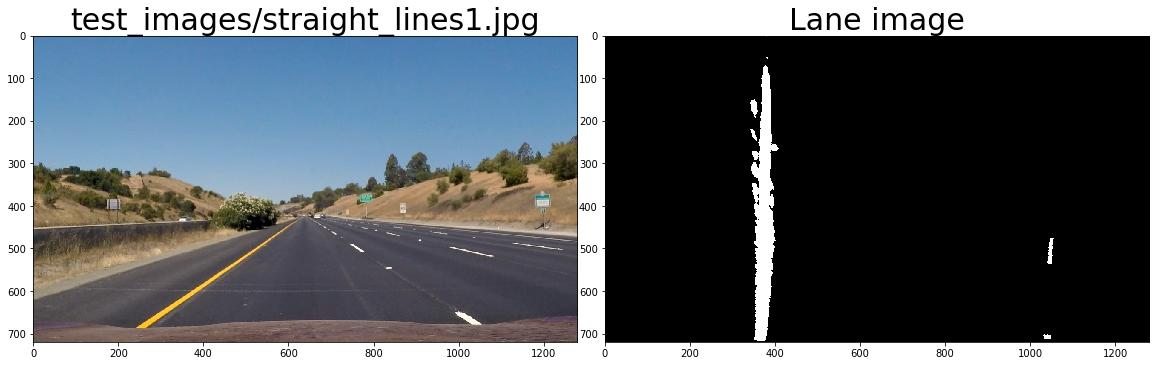

In [369]:
def  img_processing_pipeleine(img):
    # Undistort
    img_undistort = cal_undistort(img, mtx, dist) # mtx and dist are availabe having been calculated already
    
    # Perspective Transform
    warped = do_perspective_transform(img_undistort)

    # Sobel Absolute and Sobel Maginitude (using default parameters)
    img_sobelAbsMag = dir_mag_sobel_update(warped)
    
    # RGB R channel Threshold 
    img_RGB_R = R_threshold(warped,(150,221))
    
    # HLS S-channel Threshold 
    img_HLS_S = S_threshold(warped,(90,255))
    
    # HLS L-channel Threshold 
    img_HLS_L = L_threshold(warped,(220,255))

    # HSV V-channel Threshold 
    img_HSV_V = V_threshold(warped,(120,255))

    # Lab L-channel Threshold 
    img_LAB_L = Lab_L_threshold(warped,(125,250))
    
    # Lab B-channel Threshold 
    img_LAB_B = Lab_B_threshold(warped,(190,255))
    
    # Combine all the above 
    combined = np.zeros_like(img_HLS_L)
    combined[(img_HLS_L == 1) | (img_LAB_B == 1)]=1 #| (img_HLS_S == 1) | (img_HSV_V == 1) | (img_LAB_L == 1)] = 1
    return combined

# test_image = mpimg.imread("test_images/straight_lines1.jpg")
# out_img = img_processing_pipeleine(test_image)
# # Visualize Final Image Processed
# visualize_Image(test_image,out_img,'Test Image','Lane image')
images = glob.glob('test_images/test*.jpg')
for each in images:
    #print(each[33:38])
    test_img = mpimg.imread(each)
    out_img=img_processing_pipeleine(test_img)
    visualize_Image(test_img,out_img,str(each),'Lane image')
    # Save all perspective transformed images in output_images folder
    #cv2.imwrite("output_images/perspective_transformed_images/"+each[33:38]+".jpg",warped)
images = glob.glob('test_images/straight_lines*.jpg')
for each in images:
    #print(each[33:48])
    test_img = mpimg.imread(each)
    out_img=img_processing_pipeleine(test_img)
    visualize_Image(test_img,out_img,str(each),'Lane image')
    #Save all perspective transformed images in output_images folder
    #cv2.imwrite("output_images/perspective_transformed_images/"+each[33:48]+".jpg",warped)    
